# Model Fitting II

### Addressing Endogeneity

To address the issue of endogeneity we need to find instruments for hours of studying that have the following characteristics:

* $\mathrm{Cov}[z, studying] \ne 0 \ \quad$ (hours of studying covaries with $z$)
* $\mathrm{Cov}[z, \varepsilon] = 0 \ \ \ \quad\quad\quad$ ($z$ is exogenous)

Looking at the variables in our dataset, `school_GP`, `goout`, and `male` are valid instruments we can use for our analysis. In addition, based off our two way frequency table (see Data Exploration) we found that 49 people stated they had picked the school because of its proximity to home and that they had a commute time greater than 15 minutes. This subset eliminates people that may have picked the school for reasons that may directly affect how much their test scores (e.g. Picking a school because of "Courses" might correlate with test scores) and only affects test scores indirectly through study time. Thus we can use this combination of variables as an artificial instrument.

Below we will use our instruments in a 2 stage least squares regression.


In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import quadratic2SLS as q2sls

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [2]:
#Load in cleaned data and resutls from our naive OLS fit
student_both = pd.read_pickle('data/student_both_v3.pkl')
student_por  = pd.read_pickle('data/student_por_v3.pkl')
student_mat  = pd.read_pickle('data/student_mat_v3.pkl')

In [82]:
# Variable Name Selection
### Note that we leave out `reason_*` and `traveltime_*` because 
### those variables are used in constructing the artificial instrument

# names for individual course datasets
exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               #'goout_1', 'goout_2', 'goout_4', 'goout_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# names for both course datasets (includes `course_math` indicator)
exog_names2 = ['school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               #'goout_1', 'goout_2', 'goout_4', 'goout_5',
               'health_1', 'health_2', 'health_4', 'health_5']

### 2SLS Model Fitting

*Note:* The write up explains why 2SLS might not be the best method for identifying $\beta$ in this setting. We include 2SLS results to compare the non standard Q2SLS results to a more familiar model.

In [89]:
# Running the 2SLS model

# ----- Both Courses -----
# Dependent variable
Y = student_both.G3_perc

# Exogenous variables
X_exog = student_both[exog_names2]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_both[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z = student_both[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus']]

model2SLS_both = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_both = model2SLS_both.fit()


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
#student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus']]

model2SLS_por = IV2SLS(Y2, X_exog2, X_endog2, Z2)
results2SLS_por = model2SLS_por.fit()


# ----- Mathematics Course -----
# Dependent variable
Y3 = student_mat.G3_perc

# Exogenous variables
X_exog3 = student_mat[exog_names]
X_exog3 = sm.add_constant(X_exog3)

# Endogenous variable
X_endog3 = student_mat[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
#student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z3 = student_mat[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus']]

model2SLS_mat = IV2SLS(Y3, X_exog3, X_endog3, Z3)
results2SLS_mat = model2SLS_mat.fit()

In [90]:
results2SLS_both.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                      0.0561
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0005
No. Observations:                1044   F-statistic:                    387.76
Date:                Thu, May 17 2018   P-value (F-stat)                0.0000
Time:                        13:13:16   Distribution:                 chi2(58)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.5305     0.1279     4.1470     0.0000      0.2798      0.7812
school_GP                   0.0532     0.0243     2.1868     0.0288      0.0055      0.1010
course_math                -0.0936     0.0165    -5.6647     0.0000     -0.1259     -0.0612
male                        0.0048     0.0379     0.1253     0.9003     -0.0695      0.0790
age                        -0.0026     0.0121    -0.2178     0.8276     -0.0263      0.0210
urban                       0.0100     0.0164     0.6113     0.5410     -0.0221      0.0422
fam_small                   0.0293     0.0177     1.6573     0.0975     -0.0053      0.0639
fam_split                  -0.0125     0.0264    -0.4736     0.6358     -0.0641      0.0392
mother                     -0.0473     0.0316    -1.4965     0.1345     -0.1093      0.0147
father                     -0.0108     0.0323    -0.3349     0.7377     -0.0741      0.0525
failures                   -0.0938     0.0164    -5.7280     0.0000     -0.1259     -0.0617
school_sup                 -0.0591     0.0194    -3.0533     0.0023     -0.0970     -0.0212
famsup                     -0.0111     0.0162    -0.6853     0.4931     -0.0428      0.0206
paid                        0.0134     0.0217     0.6175     0.5369     -0.0291      0.0559
activities               1.814e-05     0.0166     0.0011     0.9991     -0.0325      0.0326
nursery                    -0.0038     0.0173    -0.2210     0.8251     -0.0377      0.0300
higher                      0.0779     0.0524     1.4856     0.1374     -0.0249      0.1806
internet                    0.0247     0.0176     1.4052     0.1600     -0.0098      0.0593
romantic                   -0.0488     0.0314    -1.5535     0.1203     -0.1103      0.0128
absences                    0.0002     0.0016     0.1473     0.8829     -0.0029      0.0033
Mjob_teach                 -0.0335     0.0329    -1.0173     0.3090     -0.0981      0.0310
Mjob_health                -0.0003     0.0468    -0.0054     0.9957     -0.0919      0.0914
Mjob_civil                  0.0211     0.0222     0.9480     0.3432     -0.0225      0.0646
Mjob_other                 -0.0072     0.0178    -0.4028     0.6871     -0.0419      0.0276
Fjob_teach                  0.0497     0.0448     1.1096     0.2672     -0.0381      0.1376
Fjob_health                 0.0582     0.0849     0.6860     0.4927     -0.1082      0.2246
Fjob_civil                  0.0023     0.0375     0.0616     0.9509     -0.0712      0.0758
Fjob_other                  0.0068     0.0364     0.1877     0.8511     -0.0644      0.0781
Medu_primary               -0.0434     0.0327    -1.3276     0.1843     -0.1074      0.0207
Medu_5_9                   -0.0350     0.0220    -1.5931     0.1111     -0.0781      0.0081
Medu_higher                 0.0349     0.0253     1.3816     0.1671     -0.0146      0.0845
Fedu_primary   

In [61]:
results2SLS_por.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.5365
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6961
No. Observations:                 649   F-statistic:                    187.46
Date:                Thu, May 17 2018   P-value (F-stat)                0.0000
Time:                        12:59:47   Distribution:                 chi2(61)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.2313     0.2536     0.9122     0.3617     -0.2657      0.7283
school_GP                   0.0944     0.0460     2.0540     0.0400      0.0043      0.1844
male                       -0.0939     0.0748    -1.2548     0.2095     -0.2406      0.0528
age                         0.0304     0.0297     1.0255     0.3051     -0.0277      0.0886
urban                       0.0184     0.0206     0.8934     0.3716     -0.0220      0.0588
fam_small                   0.0063     0.0244     0.2565     0.7976     -0.0416      0.0542
fam_split                   0.0067     0.0442     0.1524     0.8789     -0.0799      0.0934
mother                     -0.0276     0.0569    -0.4844     0.6281     -0.1390      0.0839
father                     -0.0124     0.0471    -0.2637     0.7920     -0.1048      0.0799
failures                   -0.0844     0.0210    -4.0111     0.0001     -0.1257     -0.0432
school_sup                 -0.0383     0.0337    -1.1356     0.2561     -0.1044      0.0278
famsup                      0.0123     0.0252     0.4865     0.6266     -0.0372      0.0617
paid                       -0.0263     0.0355    -0.7403     0.4591     -0.0958      0.0433
activities                  0.0302     0.0259     1.1640     0.2444     -0.0207      0.0811
nursery                    -0.0005     0.0217    -0.0216     0.9828     -0.0431      0.0421
higher                      0.1719     0.1119     1.5360     0.1245     -0.0474      0.3912
internet                    0.0055     0.0227     0.2413     0.8093     -0.0391      0.0500
romantic                    0.0195     0.0604     0.3222     0.7473     -0.0989      0.1378
absences                   -0.0053     0.0043    -1.2146     0.2245     -0.0138      0.0032
Mjob_teach                  0.0178     0.0476     0.3749     0.7077     -0.0754      0.1111
Mjob_health                 0.0050     0.0560     0.0891     0.9290     -0.1047      0.1147
Mjob_civil                  0.0209     0.0267     0.7829     0.4337     -0.0315      0.0733
Mjob_other                 -0.0042     0.0238    -0.1751     0.8610     -0.0508      0.0425
Fjob_teach                 -0.0155     0.0806    -0.1925     0.8474     -0.1734      0.1424
Fjob_health                -0.0439     0.1290    -0.3406     0.7334     -0.2967      0.2089
Fjob_civil                 -0.0369     0.0490    -0.7533     0.4512     -0.1329      0.0591
Fjob_other                 -0.0329     0.0607    -0.5418     0.5880     -0.1518      0.0860
Medu_primary               -0.0026     0.0394    -0.0647     0.9484     -0.0799      0.0748
Medu_5_9                   -0.0191     0.0265    -0.7212     0.4708     -0.0711      0.0328
Medu_higher                 0.0099     0.0348     0.2847     0.7759     -0.0583      0.0782
Fedu_primary               -0.0235     0.0395    -0.5939     0.5526     -0.1010      0.0540
Fedu_5_9       

In [62]:
results2SLS_mat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.9067
Estimator:                    IV-2SLS   Adj. R-squared:                -2.4392
No. Observations:                 395   F-statistic:                    98.006
Date:                Thu, May 17 2018   P-value (F-stat)                0.0019
Time:                        12:59:47   Distribution:                 chi2(61)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.5820     0.6485     0.8974     0.3695     -0.6891      1.8530
school_GP                   0.0694     0.1438     0.4823     0.6296     -0.2126      0.3513
male                        0.0876     0.0982     0.8920     0.3724     -0.1048      0.2800
age                        -0.0234     0.0284    -0.8230     0.4105     -0.0792      0.0323
urban                      -0.0497     0.1126    -0.4414     0.6589     -0.2704      0.1710
fam_small                   0.0794     0.0856     0.9283     0.3533     -0.0883      0.2472
fam_split                  -0.0552     0.1038    -0.5316     0.5950     -0.2587      0.1483
mother                     -0.0752     0.0899    -0.8365     0.4028     -0.2513      0.1009
father                      0.0218     0.1332     0.1633     0.8703     -0.2394      0.2829
failures                   -0.1279     0.0673    -1.9007     0.0573     -0.2598      0.0040
school_sup                 -0.0599     0.0643    -0.9323     0.3512     -0.1859      0.0661
famsup                     -0.0282     0.0501    -0.5622     0.5740     -0.1264      0.0700
paid                        0.0356     0.0569     0.6243     0.5324     -0.0761      0.1472
activities                 -0.0308     0.0471    -0.6534     0.5135     -0.1231      0.0616
nursery                     0.0394     0.0798     0.4940     0.6213     -0.1169      0.1957
higher                      0.0465     0.1106     0.4204     0.6742     -0.1703      0.2633
internet                    0.0738     0.0811     0.9094     0.3631     -0.0852      0.2327
romantic                   -0.1534     0.1451    -1.0569     0.2905     -0.4377      0.1310
absences                    0.0005     0.0044     0.1047     0.9166     -0.0082      0.0091
Mjob_teach                 -0.1756     0.1443    -1.2174     0.2235     -0.4584      0.1071
Mjob_health                -0.0964     0.1874    -0.5145     0.6069     -0.4638      0.2709
Mjob_civil                 -0.0100     0.0849    -0.1178     0.9062     -0.1765      0.1565
Mjob_other                 -0.0213     0.0693    -0.3073     0.7586     -0.1571      0.1145
Fjob_teach                  0.1129     0.1387     0.8140     0.4157     -0.1589      0.3847
Fjob_health                 0.2451     0.3987     0.6148     0.5387     -0.5363      1.0264
Fjob_civil                  0.1256     0.2428     0.5173     0.6049     -0.3503      0.6015
Fjob_other                  0.0652     0.1572     0.4149     0.6782     -0.2429      0.3733
Medu_primary               -0.1751     0.1897    -0.9229     0.3560     -0.5470      0.1968
Medu_5_9                   -0.0836     0.1038    -0.8055     0.4205     -0.2870      0.1198
Medu_higher                 0.0990     0.0961     1.0305     0.3028     -0.0893      0.2874
Fedu_primary                0.1597     0.2163     0.7385     0.4602     -0.2642      0.5837
Fedu_5_9       

In [63]:
#### JUST CHECKING VARIOUS PARAMETERS, DELETE THIS CHUNK LATER
results2SLS_both.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.1391
P-value: 0.7091
Distributed: chi2(1)
WaldTestStatistic, id: 0x1c20a67d68

### Q2SLS Model Fitting

In [93]:
# Running the Q2SLS model
np.random.seed(60683)   # setting random seed
n_boot = 100#0           # number of bootstrap iterations for hypothesis testing

# ----- Both Courses -----
# Dependent variable
Y1 = student_both.G3_perc

# Exogenous variables
X_exog1 = student_both[exog_names2]
X_exog1 = sm.add_constant(X_exog1)

# Endogenous variable
X_endog1 = student_both.studytime_continuous

# Instruments
#student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z1 = student_both[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus', 'goout_1', 'goout_2', 'goout_4', 'goout_5']]
#Z1 = student_both[['artificial_instrument']]

modelQ2SLS_both = q2sls.Quadratic2SLS(Y1, X_exog1, X_endog1, Z1)
resultsQ2SLS_both = modelQ2SLS_both.fit(cov_type='Bootstrap', n_iter = n_boot)


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por.studytime_continuous

# Instruments
#student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus', 'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_por = q2sls.Quadratic2SLS(Y2, X_exog2, X_endog2, Z2)
resultsQ2SLS_por = modelQ2SLS_por.fit(cov_type='Bootstrap', n_iter = n_boot)


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat.studytime_continuous

# Instruments
#student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z = student_mat[['traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus', 'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_mat = q2sls.Quadratic2SLS(Y, X_exog, X_endog, Z)
resultsQ2SLS_mat = modelQ2SLS_mat.fit(cov_type='Bootstrap', n_iter = n_boot)

100%|██████████| 100/100 [00:02<00:00, 41.82it/s]


In [94]:
# Results - Both Courses
coeff_estms_Q2SLS_both = pd.DataFrame([resultsQ2SLS_both.result2.params, resultsQ2SLS_both.beta_hat_boots.mean(axis=0), 
                                       resultsQ2SLS_both.beta_hat_boots_SE, resultsQ2SLS_both.beta_hat_boots_t, 
                                       resultsQ2SLS_both.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_both.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_both.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.5008,0.4945,0.1082,4.6273,0.0000
endog_hat,0.0206,0.0145,0.0217,0.9496,0.3426
endog_sq_hat,-0.0001,-0.0000,0.0005,-0.2224,0.8241
school_GP,0.0304,0.0332,0.0220,1.3804,0.1678
course_math,-0.0952,-0.0950,0.0166,-5.7381,0.0000
male,0.0139,0.0093,0.0259,0.5370,0.5914
age,-0.0019,-0.0010,0.0068,-0.2848,0.7758
urban,0.0226,0.0200,0.0151,1.4950,0.1352
fam_small,0.0261,0.0257,0.0137,1.8991,0.0578
fam_split,0.0007,0.0007,0.0184,0.0381,0.9696


In [95]:
# TEMPORARY TROUBLESHOOTING - checking collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_both = resultsQ2SLS_both.X_hat
# Computing the Variance Inflation Factor
vif = pd.DataFrame({
    'Feature' : X_both.columns,
    'VIF Factor' : [variance_inflation_factor(X_both.values, i) for i in range(X_both.shape[1])]
})

# Displaying the first 10 sorted VIF's after dropping the VIF for the intercept
vif.iloc[1:].sort_values(by = 'VIF Factor', ascending = False).head(10)

,Feature,VIF Factor
1,endog_hat,19.145045
47,Dalc_1,5.365956
29,Fjob_other,5.220509
2,endog_sq_hat,5.104633
38,reason_reputation,5.004614
28,Fjob_civil,4.772679
10,mother,4.732852
11,father,4.413748
48,Dalc_2,3.792408
37,reason_course,3.555868


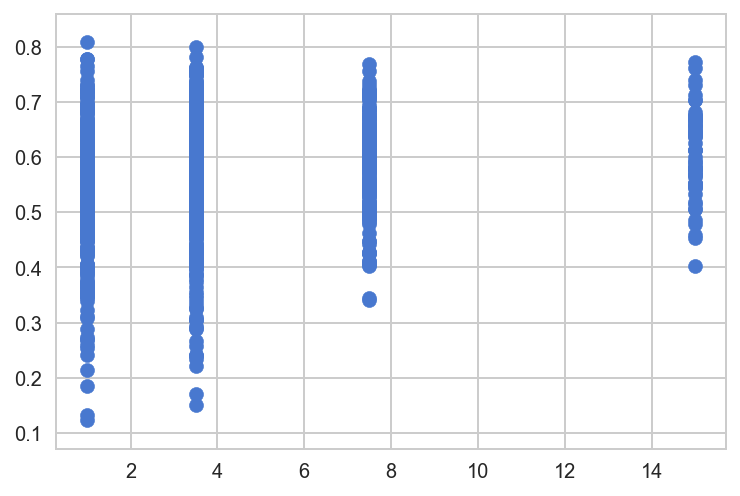

In [92]:
# TEMPORARY TROUBLESHOOTING

#print(resultsQ2SLS_both.result1A.summary())
plt.scatter(student_both.studytime_continuous, resultsQ2SLS_both.result2.fittedvalues);
#sns.violinplot(student_both.reason, student_both.traveltime)

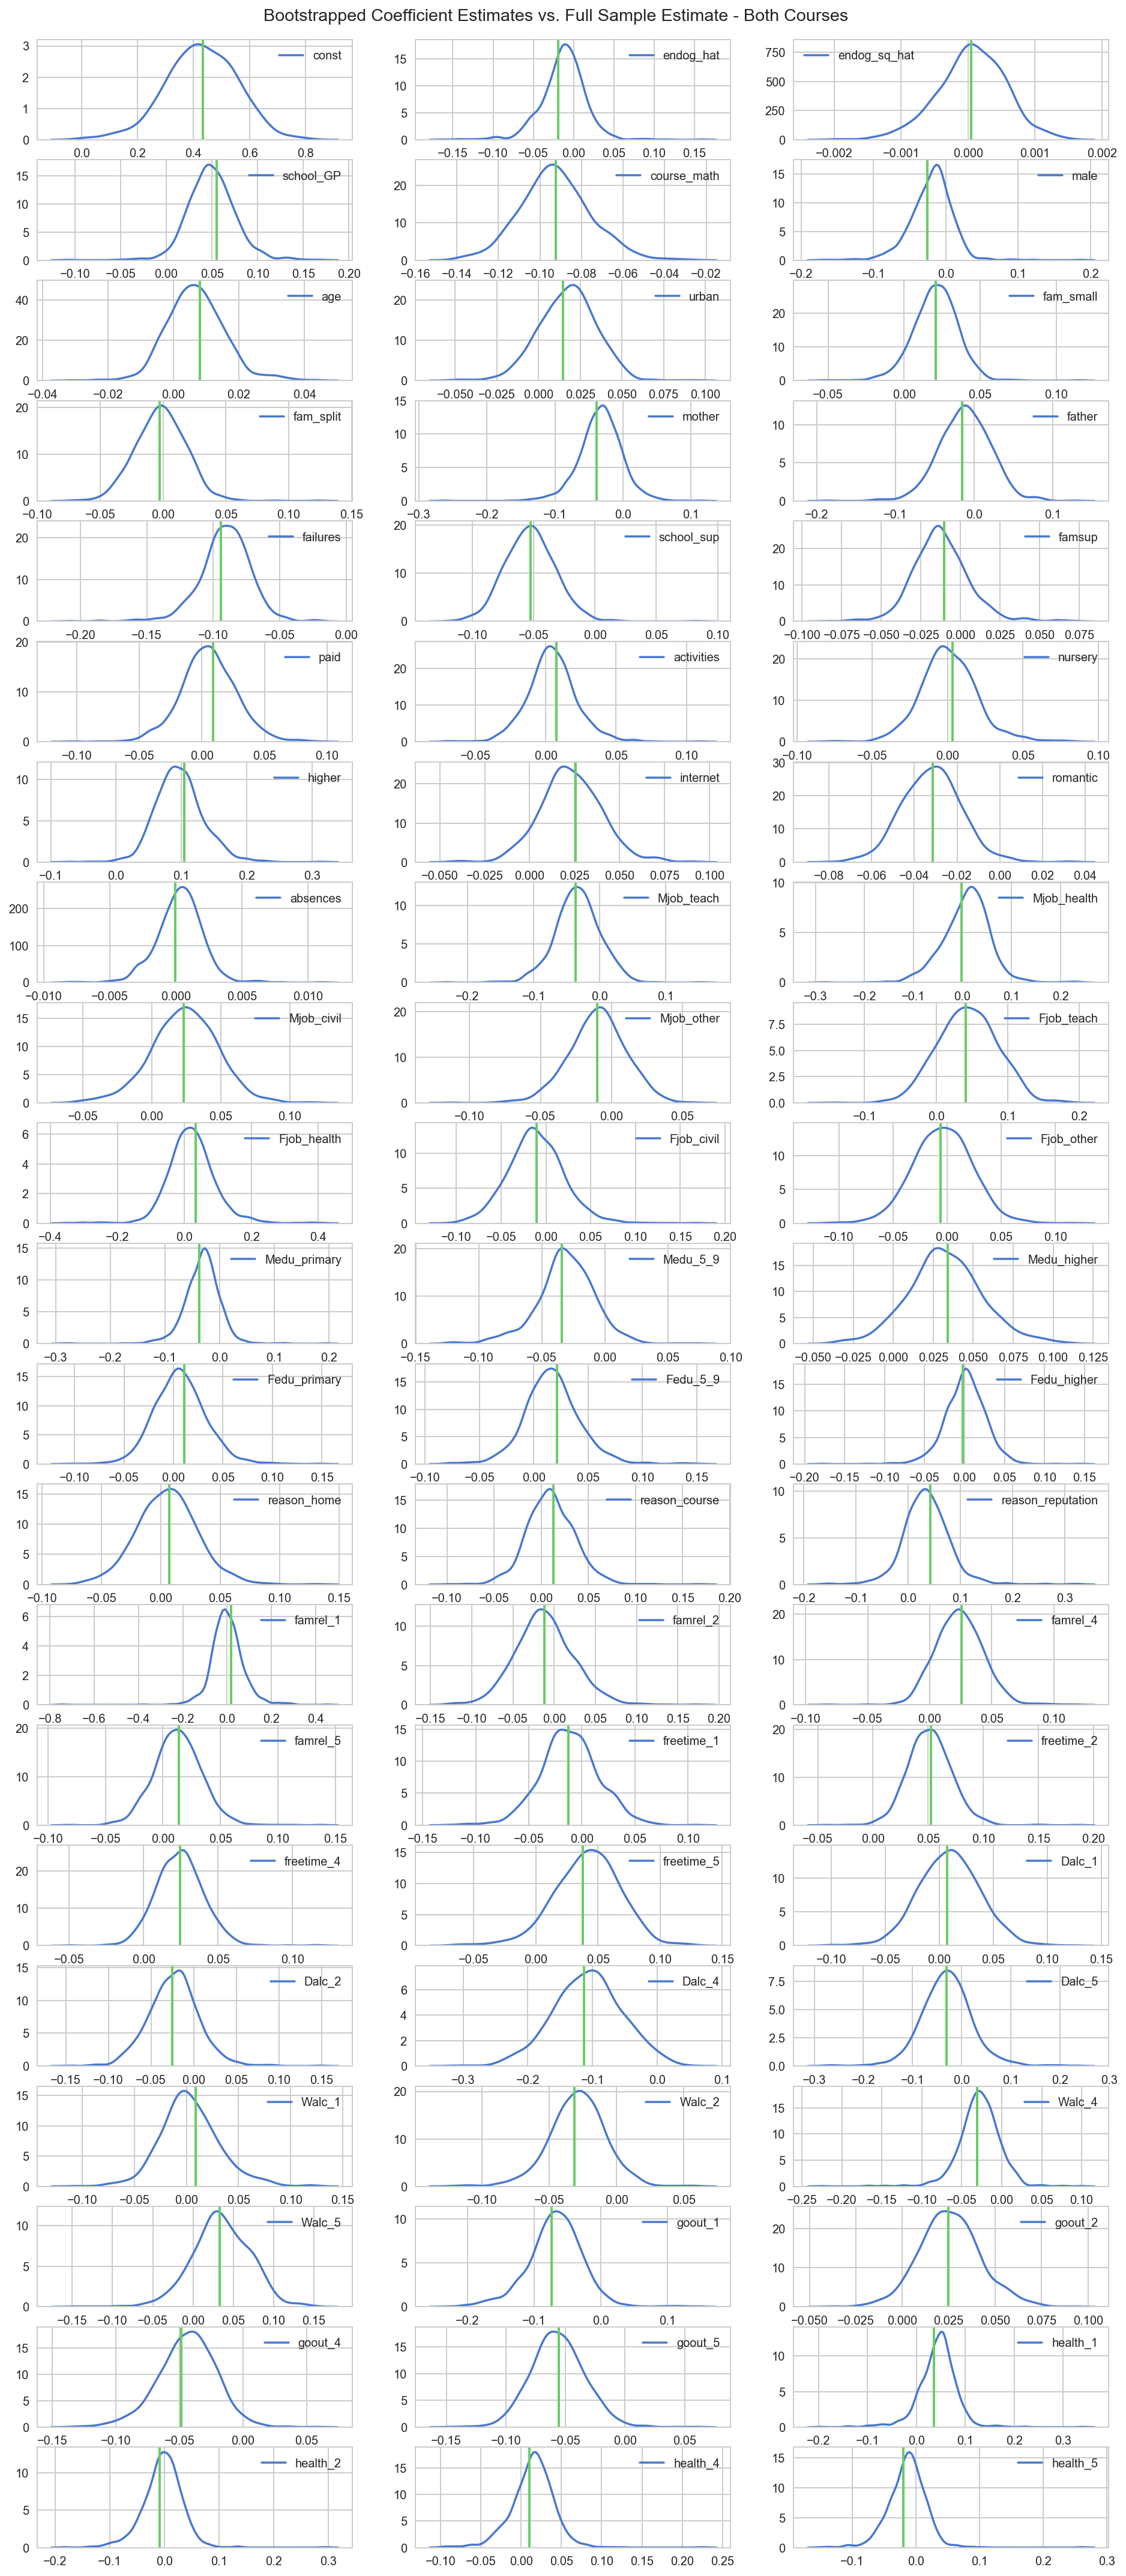

In [11]:
# Creating the plots - Both Courses
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs. Full Sample Estimate - Both Courses')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_both.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_both.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_both.result2.params[column_index], resultsQ2SLS_both.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_both.png', bbox_inches='tight');    

In [96]:
# Results - Portuguese Language Course
coeff_estms_Q2SLS_por = pd.DataFrame([resultsQ2SLS_por.result2.params, resultsQ2SLS_por.beta_hat_boots.mean(axis=0), 
                                      resultsQ2SLS_por.beta_hat_boots_SE, resultsQ2SLS_por.beta_hat_boots_t, 
                                      resultsQ2SLS_por.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_por.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_por.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.3455,0.3540,0.1085,3.1857,0.0015
endog_hat,0.0120,0.0081,0.0163,0.7357,0.4622
endog_sq_hat,0.0000,0.0001,0.0006,0.0450,0.9641
school_GP,0.0567,0.0583,0.0199,2.8545,0.0045
male,-0.0286,-0.0323,0.0174,-1.6420,0.1011
age,0.0069,0.0077,0.0058,1.1829,0.2373
urban,0.0171,0.0153,0.0164,1.0384,0.2995
fam_small,0.0168,0.0192,0.0135,1.2487,0.2123
fam_split,-0.0092,-0.0094,0.0210,-0.4386,0.6611
mother,-0.0271,-0.0293,0.0296,-0.9173,0.3594


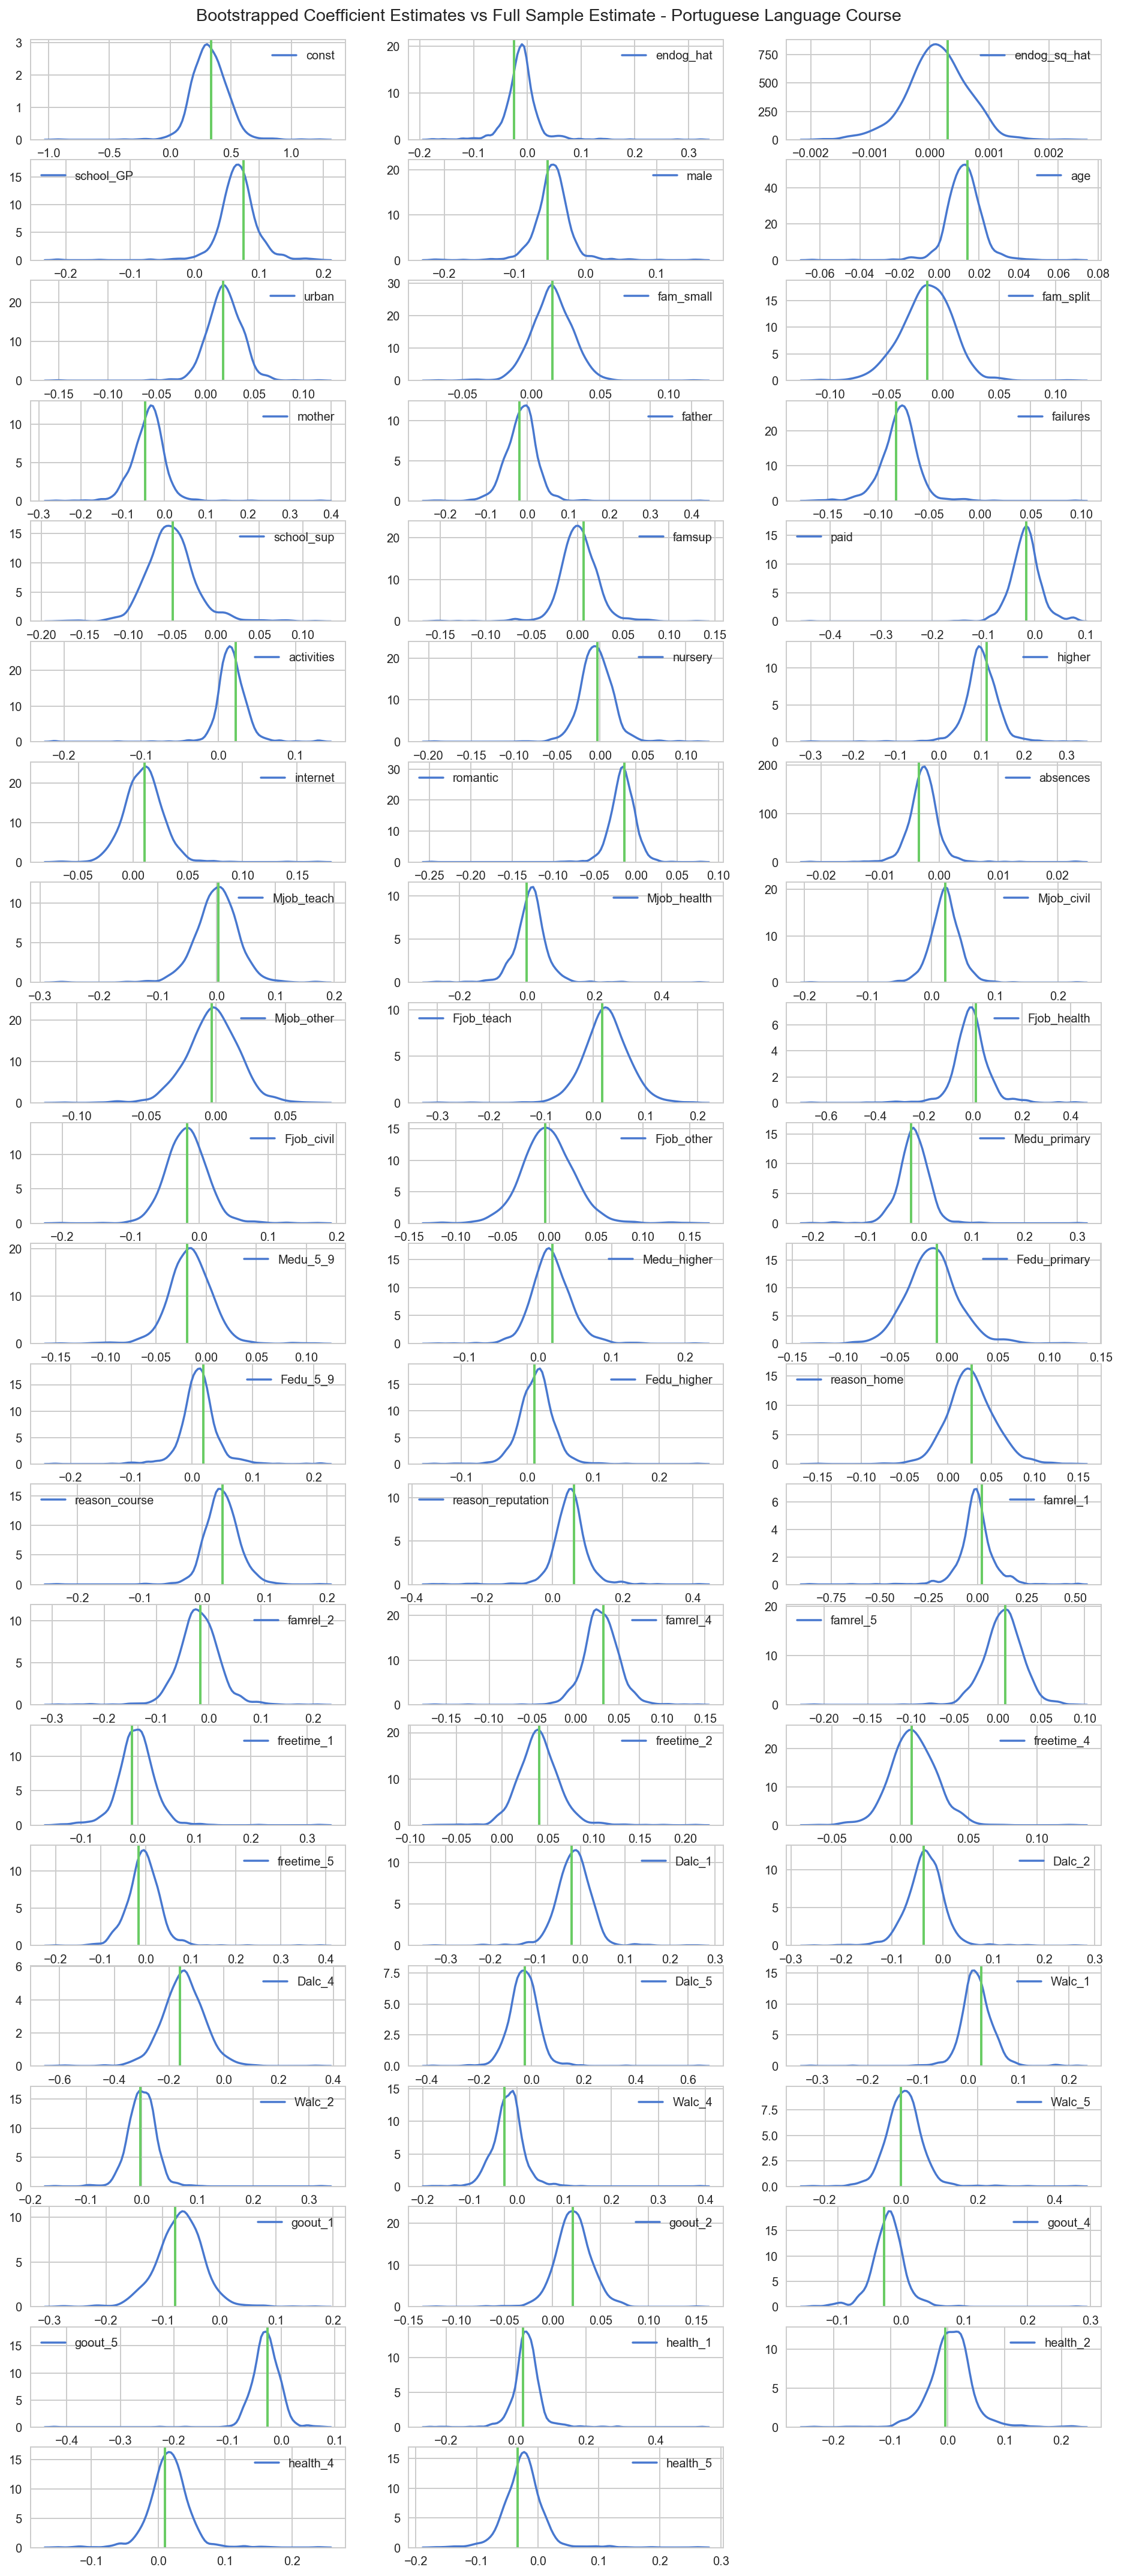

In [13]:
# Creating the plots - Portuguese Language Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Portuguese Language Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_por.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_por.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_por.result2.params[column_index], resultsQ2SLS_por.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_por.png', bbox_inches='tight');     

In [97]:
# Results - Mathematics Course
coeff_estms_Q2SLS_mat = pd.DataFrame([resultsQ2SLS_mat.result2.params, resultsQ2SLS_mat.beta_hat_boots.mean(axis=0), 
                                      resultsQ2SLS_mat.beta_hat_boots_SE, resultsQ2SLS_mat.beta_hat_boots_t, 
                                      resultsQ2SLS_mat.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_mat.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_mat.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.9102,0.9295,0.2871,3.1705,0.0017
endog_hat,0.0099,0.0081,0.0249,0.3958,0.6925
endog_sq_hat,0.0001,-0.0000,0.0006,0.2254,0.8218
school_GP,-0.0302,-0.0384,0.0436,-0.6924,0.4892
male,0.0669,0.0619,0.0485,1.3778,0.1692
age,-0.0216,-0.0225,0.0139,-1.5551,0.1209
urban,0.0253,0.0275,0.0413,0.6134,0.5401
fam_small,0.0431,0.0433,0.0254,1.6997,0.0901
fam_split,0.0079,0.0162,0.0430,0.1845,0.8537
mother,-0.0456,-0.0538,0.0537,-0.8504,0.3957


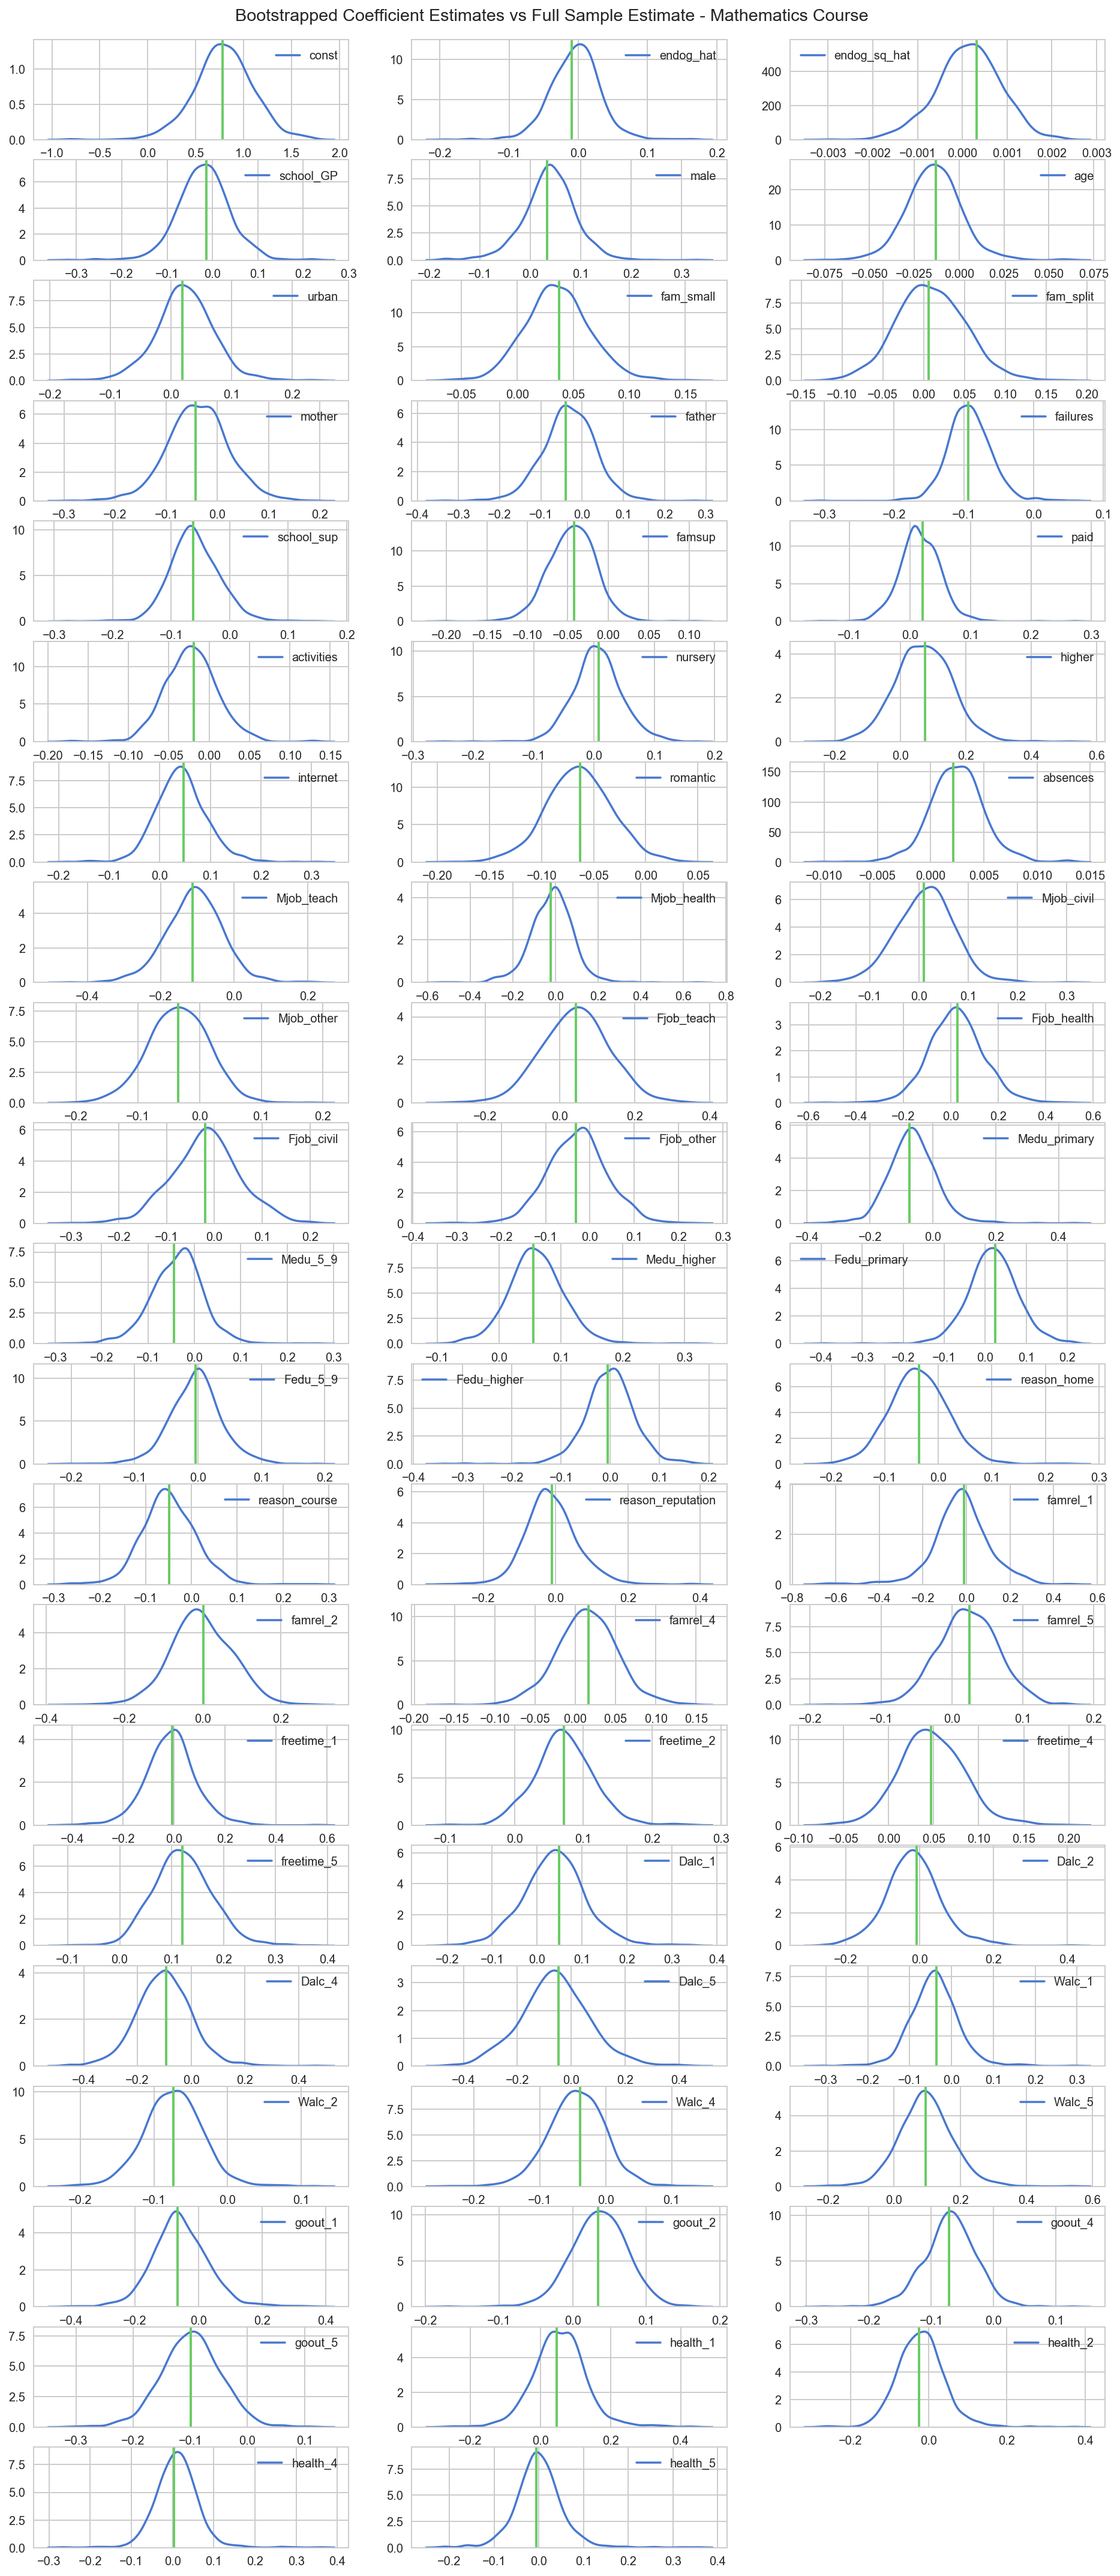

In [15]:
# Creating the plots - Mathematics Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Mathematics Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_mat.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_mat.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_mat.result2.params[column_index], resultsQ2SLS_mat.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_mat.png', bbox_inches='tight');     

In [16]:
#saving 2SLS model to our results directory
#import pickle
#with open('results/2SLS.pkl','wb') as f:
#    pickle.dump(results,f)